In [1]:
import os
import cv2
import PIL
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def make_coordinates(image, line):
    slope, intercept = line
    y1 = int(image.shape[0])# bottom of the image
    y2 = int(y1*3/5)         # slightly lower than the middle
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return [[x1, y1, x2, y2]]


In [3]:
def average_slope_intercept(image, lines):
    left_fit    = []
    right_fit   = []
    if lines is None:
        return None
    for line in lines:
        for x1, y1, x2, y2 in line:
            fit = np.polyfit((x1,x2), (y1,y2), 1)
            slope = fit[0]
            intercept = fit[1]
            if slope < 0: # y is reversed in image
                left_fit.append((slope, intercept))
            else:
                right_fit.append((slope, intercept))
    if left_fit:
        left_fit_average = np.average(left_fit, axis = 0)
        left_line = make_coordinates(image, left_fit_average)
    else:
        left_line = np.array([[0, 0, 0, 0]])
    if right_fit:
        right_fit_average = np.average(right_fit, axis = 0)
        right_line = make_coordinates(image, right_fit_average)
    else:
        right_line = np.array([[0, 0, 0, 0]])
    return np.array([left_line, right_line])


In [4]:
def canny(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)
    canny = cv2.Canny(blur, 100, 150)
    return canny

In [5]:
def region_of_interest(canny):
    height = canny.shape[0]
    width = canny.shape[1]
    mask = np.zeros_like(canny)
    ignore_mask_color = 255
    A = (100, height)       # bottom left
    B = (430, 330)          # top left
    C = (590, 330)          # top right
    D = (width, height)     # bottom right
    triangle = np.array([[A,B,C,D]], np.int32)
    cv2.fillPoly(mask, triangle, ignore_mask_color)
    masked_image = cv2.bitwise_and(canny, mask)
#     return mask # to see the mask
    return masked_image

In [6]:
def display_lines(img, lines):
    line_image = np.zeros_like(img)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(line_image, (x1, y1), (x2, y2), (255,0,0), 10)
    return line_image

In [7]:
def process_image(image):
    lane_image = np.copy(image)
    lane_canny = canny(lane_image)
    cropped_image = region_of_interest(lane_canny)
    lines = cv2.HoughLinesP(cropped_image, 1, np.pi/180, 50, np.array([]), minLineLength=100, maxLineGap=160)
    averaged_lines = average_slope_intercept(image, lines)
    line_image = display_lines(lane_image, averaged_lines)
    combo_image = cv2.addWeighted(lane_image, .8, line_image,1, 0)
    
    return combo_image

In [8]:
def img():
    paths = os.getcwd()+'/test_images'
    files = os.listdir(paths)
    
    for num, x in enumerate(files):
        
        image = cv2.imread('./test_images/'+x)
        lane_image = np.copy(image)
        result = process_image(image)
        
        fig, axs = plt.subplots(1, 2, figsize=(15, 20))
        fig.tight_layout()

        axs[0].imshow(result)
        axs[0].set_title(x.split('.')[0]+" COMBO_IMAGE")
        axs[1].imshow(lane_image)
        axs[1].set_title(x.split('.')[0]+" ORIGINAL_IMAGE")

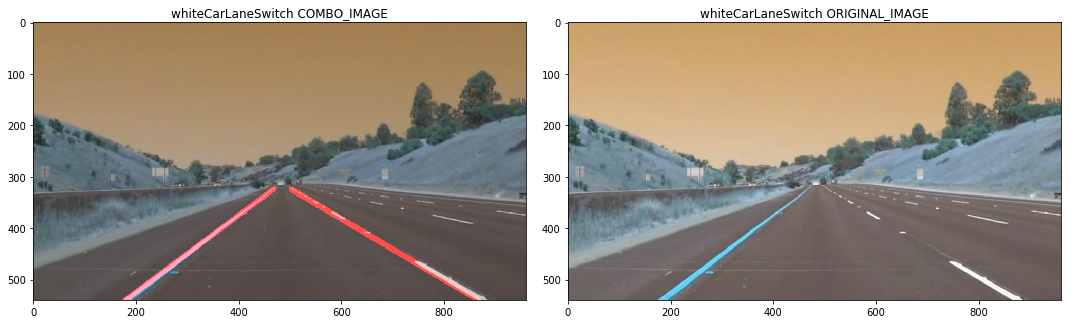

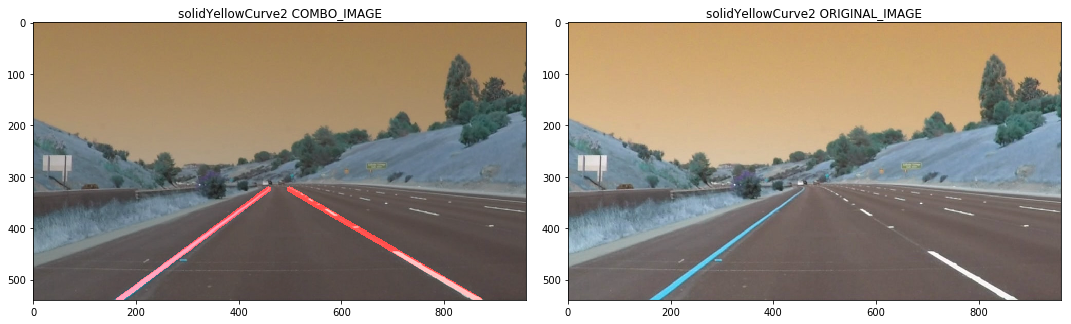

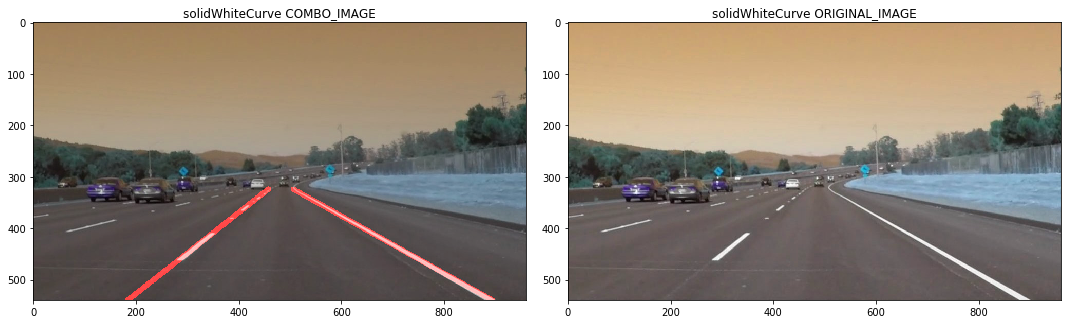

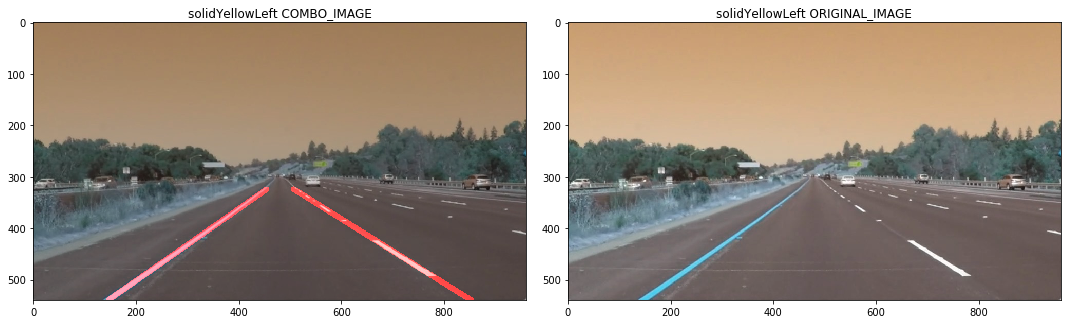

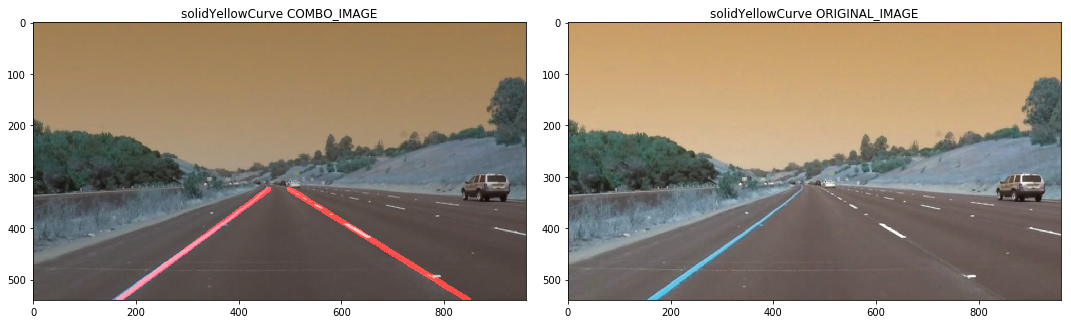

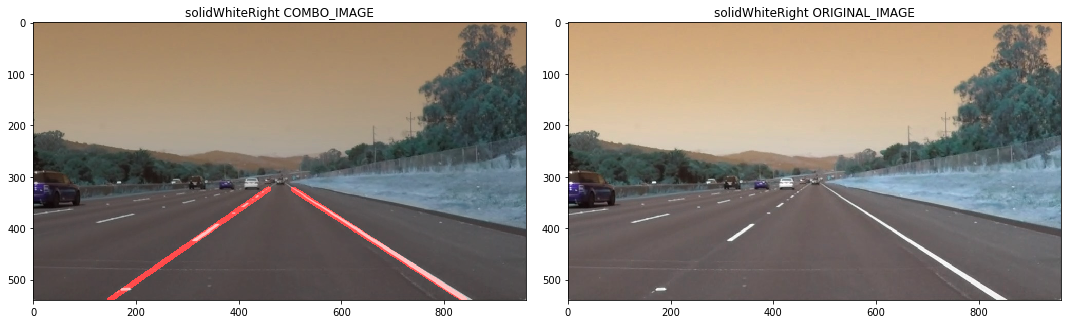

In [9]:
img()

In [10]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
def vid():
    paths = os.getcwd()+'/test_videos'
    files = os.listdir(paths)
    for num, x in enumerate(files):
            
        white_output = 'test_videos_output/'+x
        clip1 = VideoFileClip('test_videos/'+x)
        white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
        %time white_clip.write_videofile(white_output, audio=False)

In [ ]:
vid()

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:14<00:00, 14.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.1 s, sys: 278 ms, total: 3.38 s
Wall time: 16.2 s
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


 40%|███▉      | 272/682 [00:17<00:28, 14.32it/s]